In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
data = pd.read_csv("local_data/temp_data.csv")

In [8]:
data = data.sort_values("price", ascending=True).head(3080)

In [9]:
numerical_data = data.filter(data.select_dtypes(["float64", "int64"]).columns)
numerical_data = numerical_data.fillna(numerical_data.median()).dropna(axis=1)
drop_cols = [
    "id",
    "host_id",
    "name",
    "neighbourhood_group",
    "neighbourhood",
    "last_review",
    "scrape_id",
    "price_per_person",
]
numerical_data = numerical_data.drop(columns=drop_cols, errors="ignore")
# numerical_data = numerical_data[
#     numerical_data["price"] < numerical_data["price"].quantile(0.99)
# ]

In [10]:
def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    transformed_df = df.copy()

    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if "price" in numeric_cols:
        numeric_cols.remove("price")

    sqrt_df = df[numeric_cols].apply(lambda x: np.sqrt(x - x.min() + 1))
    sqrt_df.columns = [f"sqrt_{col}" for col in numeric_cols]

    log_df = df[numeric_cols].apply(lambda x: np.log(x - x.min() + 1))
    log_df.columns = [f"log_{col}" for col in numeric_cols]

    # winsorisation
    wins_df = df[numeric_cols].apply(
        lambda x: stats.mstats.winsorize(x, limits=[0.023, 0.023])
    )
    wins_df.columns = [f"wins_{col}" for col in numeric_cols]

    return pd.concat([transformed_df, sqrt_df, log_df, wins_df], axis=1)


numerical_data_transformed = transform_features(numerical_data)

In [11]:
X = numerical_data_transformed.drop("price", axis=1)
y = numerical_data["price"]

In [12]:
numerical_data_transformed.sort_values("price", ascending=False).head(20)

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,wins_tourism_sportsactivitylocation,wins_tourism_store,wins_tourism_touristattraction,wins_tourism_winery,wins_tourism_zoo,wins_tourism_total,wins_tourism_points_within_radius,wins_noise_day,wins_noise_night,wins_noise_points_within_radius
1346,4,4,47.372840,8.540050,6,2.0,3.0,3.0,3540.0,2,...,0.089862,0.025763,1.240968,0.0,0.000153,21.914040,408,3932.887318,3253.161522,10000
2508,2,5,47.370900,8.541140,4,0.5,2.0,1.0,3200.0,1,...,0.098806,0.028790,1.240968,0.0,0.000391,23.272629,408,6941.059877,5997.960137,10000
1347,4,4,47.372840,8.540050,6,2.0,3.0,3.0,2849.0,2,...,0.089862,0.025763,1.240968,0.0,0.000153,21.914040,408,3932.887318,3253.161522,10000
1343,4,4,47.372840,8.540050,6,2.0,3.0,3.0,2450.0,2,...,0.089862,0.025763,1.240968,0.0,0.000153,21.914040,408,3932.887318,3253.161522,10000
1945,4,4,47.343501,8.531133,10,3.5,5.0,5.0,2310.0,3,...,0.051378,0.000000,0.000003,0.0,0.000000,0.095135,23,1926.165053,1673.089284,10000
1036,7,7,47.367638,8.540427,6,3.5,5.0,0.0,1600.0,1,...,0.253346,0.004771,1.013200,0.0,0.001619,10.616951,404,4277.046063,3748.509061,10000
899,1,1,47.361100,8.548930,4,1.0,1.0,1.0,1500.0,1,...,0.034521,0.147311,0.105974,0.0,0.000035,4.699158,294,5321.987545,4600.314779,10000
891,21,29,47.360430,8.521830,8,3.5,1.0,4.0,1308.0,7,...,0.077751,0.000064,0.000008,0.0,0.000022,0.437111,99,5764.029380,4970.453048,10000
1078,10,10,47.362064,8.548375,7,1.5,3.0,3.0,1221.0,1,...,0.075833,0.192789,0.246458,0.0,0.000056,6.929109,312,3246.478663,2742.523515,10000
2224,5,8,47.337830,8.539300,6,3.0,3.0,3.0,1205.0,2,...,0.017640,0.000000,0.000000,0.0,0.000000,0.375109,14,1845.010123,1564.272421,10000


In [13]:
y.describe()

count    3080.000000
mean      169.123377
std       173.920453
min        21.000000
25%        95.000000
50%       131.000000
75%       189.000000
max      3540.000000
Name: price, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [16]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-2, 3, 100),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

/Applications/anaconda3/envs/dsf/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115967.1713288147, tolerance: 37807.42828246753
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/envs/dsf/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106008.25457927585, tolerance: 35816.3045422078
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/envs/dsf/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275143.8795447983, tolerance: 35816.3045422078
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/envs/dsf/lib/p

LassoCV(alphas=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14975700e-0...
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 1.18


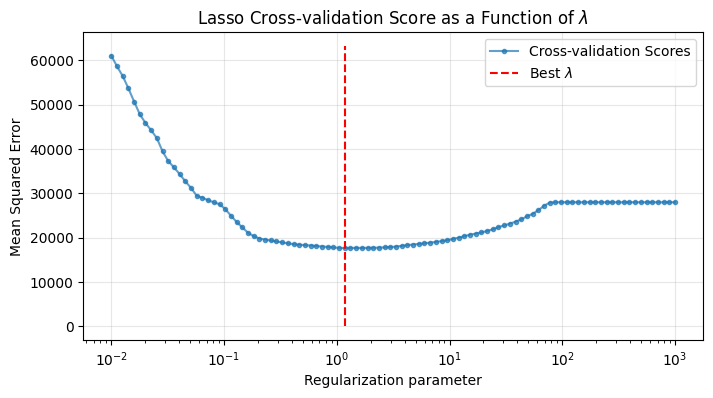

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [18]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)


evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.4777
RMSE: 120.84
MAE: 63.48

test Metrics:
R² Score: 0.2913
RMSE: 151.79
MAE: 70.92


\coeffs:
                                                  feat      coeff
46                              tourism_civicstructure  65.705662
162                         log_minimum_nights_avg_ntm -38.859830
148                            log_host_listings_count  34.794326
4                                         accommodates  32.135454
223                     wins_host_total_listings_count -28.485151
59                       tourism_performingartstheater -26.860997
264                      wins_tourism_cafeorcoffeeshop -21.423575
66                           tourism_touristattraction  18.302682
6                                             bedrooms  17.902818
159                         log_maximum_minimum_nights  16.448118
180   log_calculated_host_listings_count_private_rooms -16.059849
45                                      tourism_church -15.421981
153                                      log_bathrooms  14.716445
181    log_calculated_host_listings_count_shared_rooms -13.314474
9

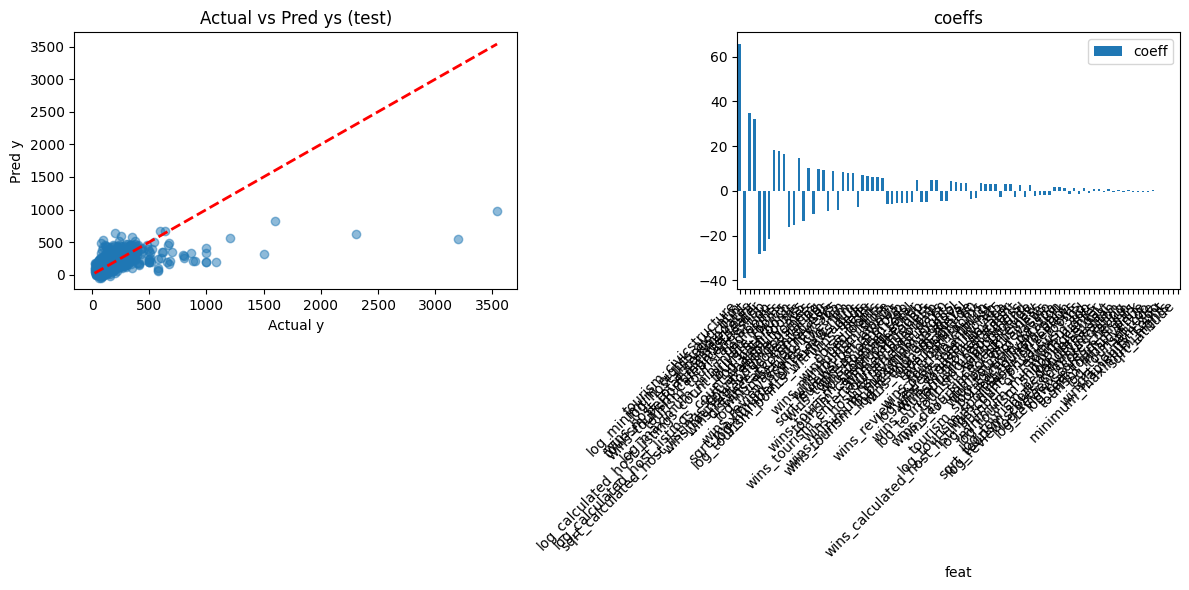

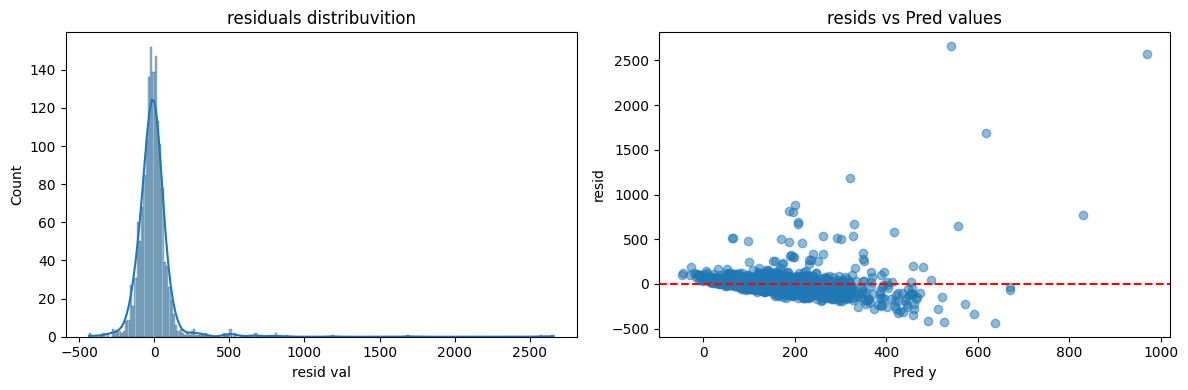

In [19]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [20]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
46,tourism_civicstructure,65.705662,65.705662
162,log_minimum_nights_avg_ntm,-38.859830,38.859830
148,log_host_listings_count,34.794326,34.794326
4,accommodates,32.135454,32.135454
223,wins_host_total_listings_count,-28.485151,28.485151
...,...,...,...
120,sqrt_tourism_civicstructure,0.000000,0.000000
121,sqrt_tourism_dayspa,0.000000,0.000000
122,sqrt_tourism_entertainmentbusiness,0.000000,0.000000
123,sqrt_tourism_hostel,-0.000000,0.000000


## RF


In [21]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


def perform_rf(X_train_scaled, y_train):
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=99,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values("importance", ascending=False)

    return mse, rmse, mae, r2, feature_importance


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    # Scatter, actual vs predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title("Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)
    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1, 0])
    axes[0, 1].set_title("Top 10 Most Important Features")
    axes[0, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()

train Metrics:
R² Score: 0.6898
MSE: 8671.20
RMSE: 93.12
MAE: 38.30
test Metrics:
R² Score: 0.3019
MSE: 22696.36
RMSE: 150.65
MAE: 62.41


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

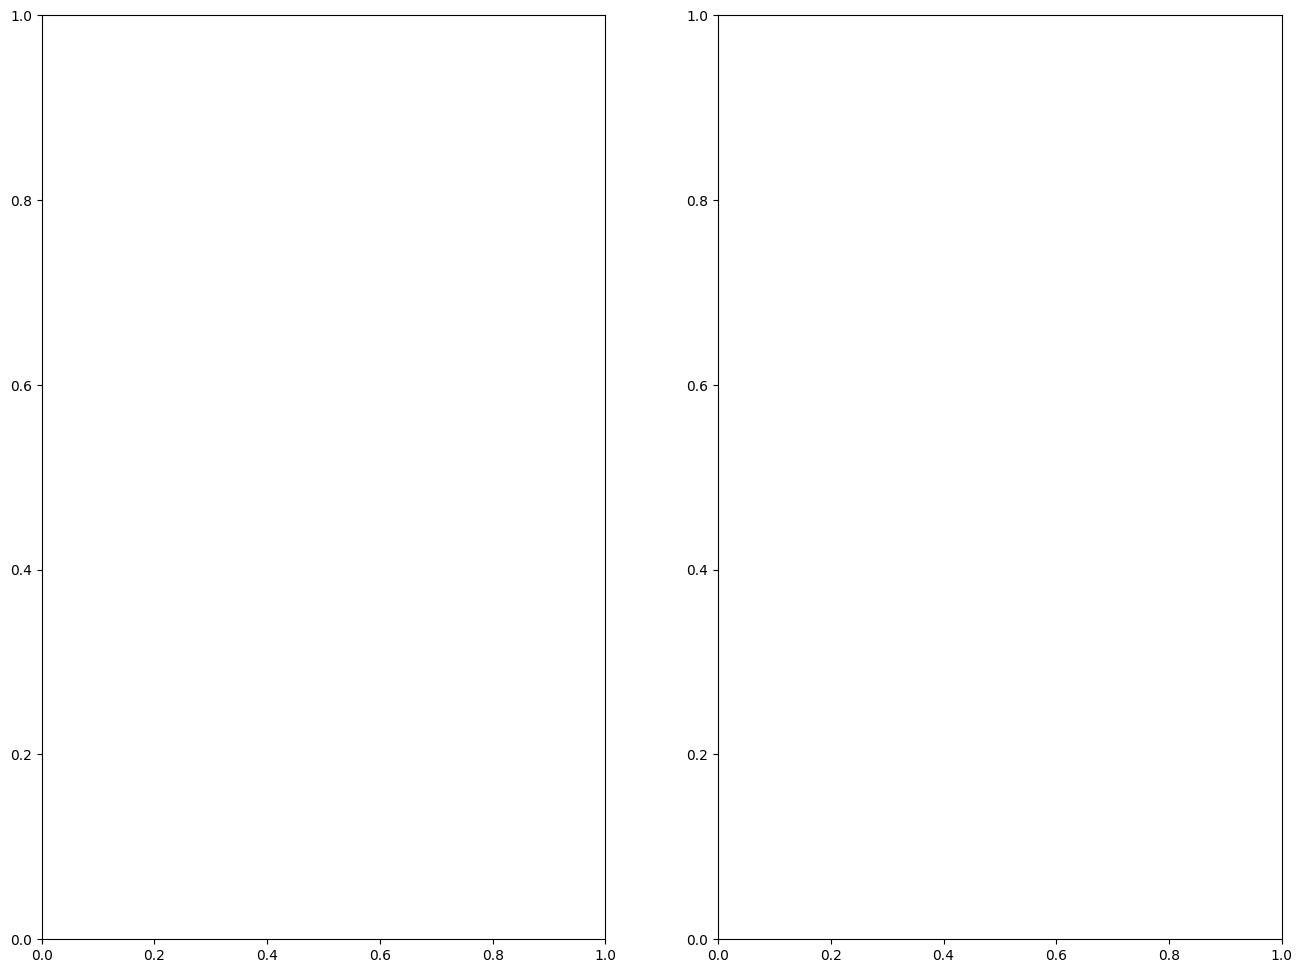

In [23]:
# Random forest

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features
evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, feature_importance
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features, or use Y_TEST_PRED_RF TO VISUALISE